In [13]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [14]:
%%capture
%load_ext autoreload
%autoreload 2
#So there is no need for reloading notebook everytime you make changes in Helpfiles.py

import pandas as pd
import numpy as np
from Helpfiles import *
from imblearn.pipeline import Pipeline
## NAIVE BAYES
from sklearn.naive_bayes import CategoricalNB, BernoulliNB
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import KFold

In [15]:
D = pd.read_csv('Myocardial infarction complications Database.csv', na_values ='?')
y = D["LET_IS"]
D = D.iloc[:, 0:D.shape[-1]-12]
D.drop("ID", axis=1, inplace=True)

X = D.copy()
#We remove initially columns with too many NA values.
RemoveColumns = ['NA_KB', 'LID_KB', 'NOT_NA_KB', 'S_AD_KBRIG', 'D_AD_KBRIG', 'IBS_NASL','KFK_BLOOD']
X = X.drop(columns = RemoveColumns)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=123)

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

In [17]:
pipeline = Pipeline([
    #("ColumnRemover", RemoveNANsColumns()),
    #("NANremoverRow", RemoveNANsRows()), #SVDimputer går galt med denne 
    ("imputer", SVDImputer()),
    ("Scaling", None),
    ("classBalance", SMOTE()),
    ("classifier", BernoulliNB())
])

In [19]:
SI = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

grid_param = [
                {"imputer":[SVDImputer(), SI],
                "classifier": [MLPClassifier(max_iter = 1000)],
                "classifier__hidden_layer_sizes": [(20,20,20,20),(100,100,100), (100, 100), (100,)],#, (100,100), (100,)] #
                 },
                {"imputer":[SVDImputer(), SI],
                "Scaling" : [StandardScaler()],
                "classifier": [LogisticRegression(max_iter = 1000)],
                 "classifier__penalty": ['l2'],
                 "classifier__class_weight": ["balanced", None],
                 "classifier__C": np.logspace(-1, 2, 5),
                 #"classifier__solver":['newton-cg','saga','sag','liblinear'] ##This solvers don't allow L1 penalty
                 },
                {"imputer":[SVDImputer(), SI],
                "classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10],
                 }]
# create a gridsearch of the pipeline, the fit the best model
CV_split = KFold(n_splits=5, random_state=123, shuffle=True)
print("OBS har lige sat grid_param[0]")
gridsearch = GridSearchCV(pipeline, grid_param[0], cv=CV_split, verbose=2, scoring='f1_macro' ) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END classifier=MLPClassifier(max_iter=1000), classifier__hidden_layer_sizes=(20, 20, 20, 20), imputer=SVDImputer(); total time=  39.1s
[CV] END classifier=MLPClassifier(max_iter=1000), classifier__hidden_layer_sizes=(20, 20, 20, 20), imputer=SVDImputer(); total time=  47.3s
[CV] END classifier=MLPClassifier(max_iter=1000), classifier__hidden_layer_sizes=(20, 20, 20, 20), imputer=SVDImputer(); total time=  49.1s
[CV] END classifier=MLPClassifier(max_iter=1000), classifier__hidden_layer_sizes=(20, 20, 20, 20), imputer=SVDImputer(); total time=  28.2s
[CV] END classifier=MLPClassifier(max_iter=1000), classifier__hidden_layer_sizes=(20, 20, 20, 20), imputer=SVDImputer(); total time=  40.6s
[CV] END classifier=MLPClassifier(max_iter=1000), classifier__hidden_layer_sizes=(20, 20, 20, 20), imputer=SimpleImputer(strategy='most_frequent'); total time=  23.2s


## Comparing to ClinTrajan and removing NAN columns (Finding RemoveColumns)

**Comparing to public available work on the same dataset (see ClinTrajan)**

I (Simon) have saved columns_ClinTrajan.txt and IDs_ClinTrajan.txt from the ClinTrajan project. Still don't know why some of the id's are ommitted in the ClinTrajan proejct! 

In [11]:
IDs = np.loadtxt("IDs_ClinTrajan.txt") # They have less ID's in their dataset?? 
D_ClinTrajan = D[D["ID"].isin(IDs)]
D_ClinTrajan.shape

(1574, 117)

In [12]:
with open('columns_ClinTrajan.txt', 'r') as file:
    columns = file.read().splitlines()

OurColumns = pd.read_csv('./Myocardial infarction complications Database.csv', na_values ='?').columns.values
NewColumns = np.array(columns)

print(np.setdiff1d(NewColumns,OurColumns))
print(np.setdiff1d(OurColumns,NewColumns))

['LET_IS_0' 'LET_IS_1' 'LET_IS_2' 'LET_IS_3' 'LET_IS_4' 'LET_IS_5'
 'LET_IS_6' 'LET_IS_7']
['D_AD_KBRIG' 'IBS_NASL' 'KFK_BLOOD' 'LET_IS' 'LID_KB' 'NA_KB' 'NOT_NA_KB'
 'S_AD_KBRIG']


Ok, so they removed some of the columns! Let's see if those are the columns, that contain most NA's

In [13]:
#Getting a better view of each single column
dic = {var:  D.groupby(var,dropna=False).ID.count() for var in D.columns}
names = list(dic.keys())

Number_of_nan_values = {} 
for name in names:
    try:
        Number_of_nan_values[name]=dic[name][dic[name].index.isna()].values[0]
    except:
        continue

Number_of_nan_values_series = pd.Series(Number_of_nan_values).sort_values()
Number_of_nan_values_series.tail(12)

ritm_ecg_p_08    152
ritm_ecg_p_06    152
ROE              203
DLIT_AG          248
D_AD_ORIT        267
S_AD_ORIT        267
ALT_BLOOD        284
AST_BLOOD        285
GIPO_K           369
K_BLOOD          371
NA_BLOOD         375
GIPER_NA         375
dtype: int64

Yes, ClinTrajan indeed removed the columns with the most Na's. We will do the same:

In [14]:
RemoveColumns = Number_of_nan_values_series.sort_values().index[-7:] #Removing the last 7 clolumns containing most NAN's
RemoveColumns

Index(['S_AD_ORIT', 'ALT_BLOOD', 'AST_BLOOD', 'GIPO_K', 'K_BLOOD', 'NA_BLOOD',
       'GIPER_NA'],
      dtype='object')

## Basic statistics

<AxesSubplot:xlabel='AGE'>

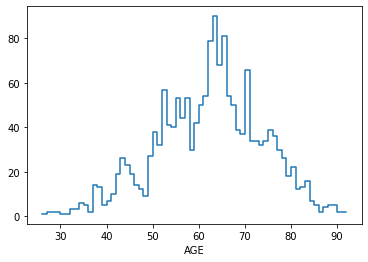

In [15]:
dic[names[1]].plot(drawstyle="steps-post")

## Imputation using SVD and maybe matrix factorization

In [16]:
D_complete = D.dropna()
print(f"There is {D_complete.shape[0]} complete rows in the dataset")

There is 544 complete rows in the dataset


In [17]:
variable_types, binary, continuous, ordinal = detect_variable_type(D,Max_Number_Of_Ordinal_Values=10,verbose=True)

AGE 	 	[ 26.0 ...  62 values... 92.0 ]	 CONTINUOUS
SEX 	 [0, 1] 	 2 	 BINARY
INF_ANAM 	 [0.0, 1.0, 2.0, 3.0] 	 4 	 ORDINAL
STENOK_AN 	 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 	 7 	 ORDINAL
FK_STENOK 	 [0.0, 1.0, 2.0, 3.0, 4.0] 	 5 	 ORDINAL
IBS_POST 	 [0.0, 1.0, 2.0] 	 3 	 ORDINAL
GB 	 [0.0, 1.0, 2.0, 3.0] 	 4 	 ORDINAL
SIM_GIPERT 	 [0.0, 1.0] 	 2 	 BINARY
DLIT_AG 	 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0] 	 8 	 ORDINAL
ZSN_A 	 [0.0, 1.0, 2.0, 3.0, 4.0] 	 5 	 ORDINAL
nr_11 	 [0.0, 1.0] 	 2 	 BINARY
nr_01 	 [0.0, 1.0] 	 2 	 BINARY
nr_02 	 [0.0, 1.0] 	 2 	 BINARY
nr_03 	 [0.0, 1.0] 	 2 	 BINARY
nr_04 	 [0.0, 1.0] 	 2 	 BINARY
nr_07 	 [0.0, 1.0] 	 2 	 BINARY
nr_08 	 [0.0, 1.0] 	 2 	 BINARY
np_01 	 [0.0, 1.0] 	 2 	 BINARY
np_04 	 [0.0, 1.0] 	 2 	 BINARY
np_05 	 [0.0, 1.0] 	 2 	 BINARY
np_07 	 [0.0, 1.0] 	 2 	 BINARY
np_08 	 [0.0, 1.0] 	 2 	 BINARY
np_09 	 [0.0, 1.0] 	 2 	 BINARY
np_10 	 [0.0, 1.0] 	 2 	 BINARY
endocr_01 	 [0.0, 1.0] 	 2 	 BINARY
endocr_02 	 [0.0, 1.0] 	 2 	 BINARY
endocr_03 	 

We are basically first defining the PCA components $\{\phi^{(1)}, \phi^{(2)}, \dots, \phi^{(n)} \}$, on the 544 complete rows, which can be used to define a basis. i.e for each data point $y$ we can write
$$y = \sum_{i=1}^n \langle y, \phi^{(i)}\rangle \phi^{(i)}$$
where $\langle y, \phi^{(j)}\rangle$ is the scalar projection of $y$ onto the i'th PCA component. We calucluate the inner products as 
$$\langle y, \phi_i\rangle = \sum_{j = 1}^m y_j\phi_{j}^{(i)}$$ 

Now, for the data containing the Nan values, we simply set all nan values and project the data using the defined PCA basis. OBS, now the trick is, that we do not inlude all PCA components, since that would simply mean that we imputed the nans with zeroes!! We only choose the first important components, say the first 3, i.e. for all $y$ which are not in the complete data set: 

$$y_{imputed} \approx \sum_{i=1}^3 \langle y, \phi^{(i)}\rangle \phi^{(i)}$$ 

Since we are dealing with ordinary/binary data types, we simply round to nearest feasible integer.   

Matrix shape: (544, 116)
Effective linear dimension 3
Full matrix shape (1700, 116)


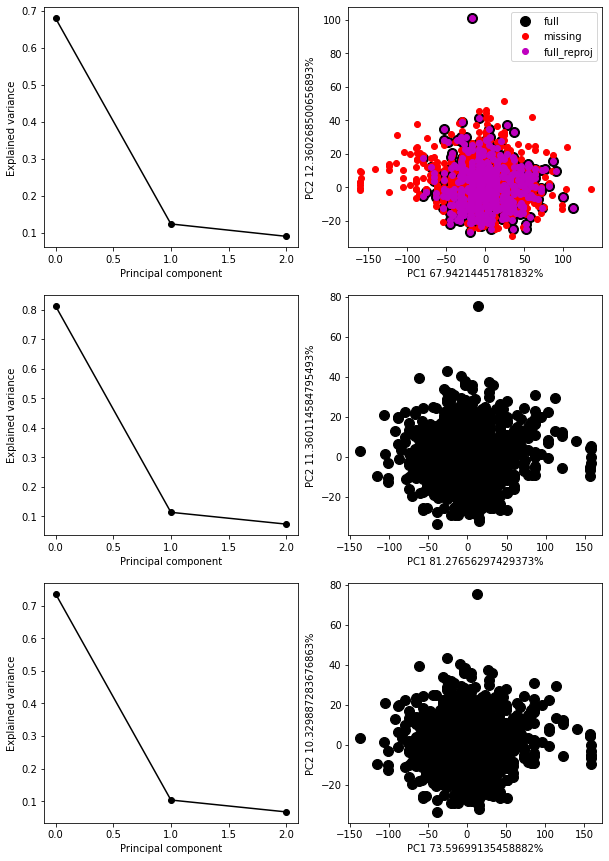

In [18]:
D_imputed = SVDcomplete_imputation_method(D,variable_types,num_components=-1,produce_plots=True,verbose=True)

In [19]:
D

ID   AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  \
0        1  77.0    1       2.0        1.0        1.0       2.0  3.0   
1        2  55.0    1       1.0        0.0        0.0       0.0  0.0   
2        3  52.0    1       0.0        0.0        0.0       2.0  2.0   
3        4  68.0    0       0.0        0.0        0.0       2.0  2.0   
4        5  60.0    1       0.0        0.0        0.0       2.0  3.0   
...    ...   ...  ...       ...        ...        ...       ...  ...   
1695  1696  77.0    0       0.0        4.0        2.0       1.0  2.0   
1696  1697  70.0    0       0.0        6.0        2.0       1.0  2.0   
1697  1698  55.0    1       3.0        6.0        2.0       2.0  0.0   
1698  1699  79.0    0       2.0        2.0        2.0       1.0  2.0   
1699  1700  63.0    1       2.0        NaN        NaN       NaN  2.0   

      SIM_GIPERT  DLIT_AG  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  \
0            0.0      7.0  ...          0           0         0          0   
1            0.0      0.0  ...          0           0         0          0   
2            0.0      2.0  ...          0           0         0          0   
3            0.0      3.0  ...          0           0         0          0   
4            0.0      7.0  ...          0           0         0          0   
...          ...      ...  ...        ...         ...       ...        ...   
1695         0.0      7.0  ...          0           0         1          0   
1696         0.0      7.0  ...          0           0         0          0   
1697         0.0      0.0  ...          0           0         0          0   
1698         0.0      7.0  ...          0           0         0          1   
1699         0.0      NaN  ...          0           0         0          0   

      RAZRIV  DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0          0         0    0       0          0       0  
1          0         0    0       0          0       0  
2          0         0    0       0          0       0  
3          0         0    1       0          0       0  
4          0         0    0       0          0       0  
...      ...       ...  ...     ...        ...     ...  
1695       1         0    0       0          0       3  
1696       0         0    0       0          0       1  
1697       0         0    0       1          0       6  
1698       0         0    0       0          0       1  
1699       0         0    0       0          0       1  

[1700 rows x 117 columns]

In [20]:
D_imputed

ID   AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  \
0        1  77.0    1       2.0        1.0        1.0       2.0  3.0   
1        2  55.0    1       1.0        0.0        0.0       0.0  0.0   
2        3  52.0    1       0.0        0.0        0.0       2.0  2.0   
3        4  68.0    0       0.0        0.0        0.0       2.0  2.0   
4        5  60.0    1       0.0        0.0        0.0       2.0  3.0   
...    ...   ...  ...       ...        ...        ...       ...  ...   
1695  1696  77.0    0       0.0        4.0        2.0       1.0  2.0   
1696  1697  70.0    0       0.0        6.0        2.0       1.0  2.0   
1697  1698  55.0    1       3.0        6.0        2.0       2.0  0.0   
1698  1699  79.0    0       2.0        2.0        2.0       1.0  2.0   
1699  1700  63.0    1       2.0        2.0        1.0       1.0  2.0   

      SIM_GIPERT  DLIT_AG  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  \
0            0.0      7.0  ...          0           0         0          0   
1            0.0      0.0  ...          0           0         0          0   
2            0.0      2.0  ...          0           0         0          0   
3            0.0      3.0  ...          0           0         0          0   
4            0.0      7.0  ...          0           0         0          0   
...          ...      ...  ...        ...         ...       ...        ...   
1695         0.0      7.0  ...          0           0         1          0   
1696         0.0      7.0  ...          0           0         0          0   
1697         0.0      0.0  ...          0           0         0          0   
1698         0.0      7.0  ...          0           0         0          1   
1699         0.0      0.0  ...          0           0         0          0   

      RAZRIV  DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0          0         0    0       0          0       0  
1          0         0    0       0          0       0  
2          0         0    0       0          0       0  
3          0         0    1       0          0       0  
4          0         0    0       0          0       0  
...      ...       ...  ...     ...        ...     ...  
1695       1         0    0       0          0       3  
1696       0         0    0       0          0       1  
1697       0         0    0       1          0       6  
1698       0         0    0       0          0       1  
1699       0         0    0       0          0       1  

[1700 rows x 117 columns]

### NMF?

In [22]:
model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(D.dropna())

/home/simon/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## Pipeline

In [4]:
pipeline = Pipeline([
    ("NANremoverCol", RemoveNANsColumns()),
    ("NANremoverRow", RemoveNANsRows()), #SVDimputer går galt med denne 
    ("SVDImputer", SVDImputer()),
    ("Classifier", BernoulliNB())
])

pipeline2 = Pipeline([
    ("SimpleImputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("Classifier", BernoulliNB())
])

In [5]:
# Define X and y
X = D.drop(columns="LET_IS")
y = D["LET_IS"]

### Show off pipeline does what it is supposed to

In [6]:
pipeline

Pipeline(steps=[('NANremoverCol', RemoveNANsColumns()),
                ('NANremoverRow', RemoveNANsRows()),
                ('SVDImputer', SVDImputer()), ('Classifier', BernoulliNB())])

In [132]:
print(pipeline[0:1].fit_transform(X).shape)
print(pipeline[1:2].fit_transform(X).shape)
print(pipeline[0:2].fit_transform(X).shape)

(1700, 116)
Problems here? in RemoveNANsRows
(1607, 123)
Problems here? in RemoveNANsRows
(1642, 116)


In [133]:
EtTal = 600
pipeline[0:2].fit_transform(X.iloc[:EtTal,:])

Problems here? in RemoveNANsRows


ID   AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  \
0      1  77.0    1       2.0        1.0        1.0       2.0  3.0   
1      2  55.0    1       1.0        0.0        0.0       0.0  0.0   
2      3  52.0    1       0.0        0.0        0.0       2.0  2.0   
3      4  68.0    0       0.0        0.0        0.0       2.0  2.0   
4      5  60.0    1       0.0        0.0        0.0       2.0  3.0   
..   ...   ...  ...       ...        ...        ...       ...  ...   
595  596  70.0    1       0.0        6.0        2.0       1.0  0.0   
596  597  44.0    1       0.0        0.0        0.0       0.0  0.0   
597  598  52.0    1       0.0        3.0        2.0       1.0  0.0   
598  599  67.0    1       1.0        0.0        0.0       0.0  3.0   
599  600  65.0    1       0.0        4.0        2.0       1.0  2.0   

     SIM_GIPERT  DLIT_AG  ...  PREDS_TAH  JELUD_TAH  FIBR_JELUD  A_V_BLOK  \
0           0.0      7.0  ...          0          0           0         0   
1           0.0      0.0  ...          0          0           0         0   
2           0.0      2.0  ...          0          0           0         0   
3           0.0      3.0  ...          0          0           0         0   
4           0.0      7.0  ...          0          0           0         0   
..          ...      ...  ...        ...        ...         ...       ...   
595         0.0      0.0  ...          0          0           0         0   
596         0.0      0.0  ...          0          0           0         0   
597         0.0      0.0  ...          0          0           0         0   
598         0.0      7.0  ...          0          0           0         0   
599         0.0      NaN  ...          0          0           0         0   

     OTEK_LANC  RAZRIV  DRESSLER  ZSN  REC_IM  P_IM_STEN  
0            0       0         0    0       0          0  
1            0       0         0    0       0          0  
2            0       0         0    0       0          0  
3            0       0         0    1       0          0  
4            0       0         0    0       0          0  
..         ...     ...       ...  ...     ...        ...  
595          0       0         0    0       0          0  
596          0       0         0    0       0          0  
597          0       0         0    0       0          0  
598          0       0         0    1       0          0  
599          0       0         0    0       0          0  

[590 rows x 117 columns]

In [134]:

DD = pipeline.fit(X.iloc[:EtTal,:],y[:EtTal])
y_hat = DD.predict(X.iloc[EtTal:,:])

Problems here? in RemoveNANsRows


ValueError: Found input variables with inconsistent numbers of samples: [590, 600]

OK, RemoveNANsRows yilds mistakes! I think I know why. Anyway, let's drop RemoveNANsRows

In [7]:
pipeline.set_params(NANremoverRow=None)

Pipeline(steps=[('NANremoverCol', RemoveNANsColumns()), ('NANremoverRow', None),
                ('SVDImputer', SVDImputer()), ('Classifier', BernoulliNB())])

In [8]:
DD = pipeline.fit(X.iloc[:EtTal,:],y[:EtTal])
y_hat = DD.predict(X.iloc[EtTal:,:])

NameError: name 'EtTal' is not defined

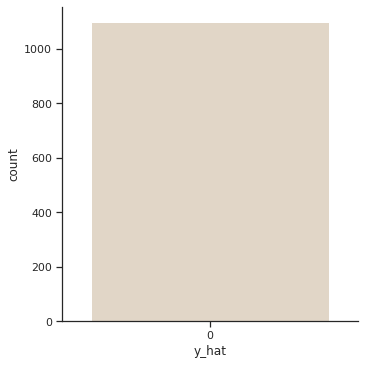

In [137]:
import seaborn as sns
sns.set_theme(style="ticks")
y_predictions = pd.DataFrame({"y": y[EtTal:], "y_hat":y_hat})
sns.catplot(x="y_hat", kind="count", data=y_predictions,palette="ch:.25" );

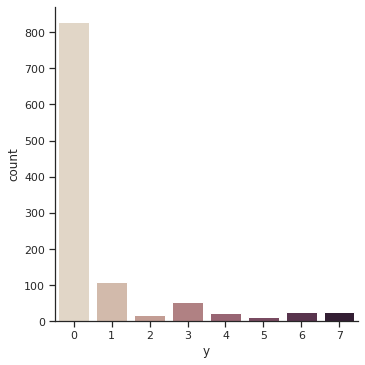

In [138]:
sns.catplot(x="y", kind="count", data=y_predictions,palette="ch:.25" );

### And it works on Automatic CV 

In [139]:
# Neural Network
nnet = MLPClassifier()
pipeline.set_params(Classifier =  nnet)
scores = cross_val_score(pipeline, X, y, cv = 3)
print('Test accuracy: ', np.mean(scores), '\nTest accuracy for each fold', scores)

Test accuracy:  0.7321685643240413 
Test accuracy for each fold [0.86772487 0.91005291 0.41872792]


In [9]:
pipeline

Pipeline(steps=[('NANremoverCol', RemoveNANsColumns()), ('NANremoverRow', None),
                ('SVDImputer', SVDImputer()), ('Classifier', BernoulliNB())])

In [10]:
# Random Forest (with default hyperpars)

clf = RandomForestClassifier()
pipeline.set_params(Classifier =  clf)
CV_score = cross_val_score(pipeline, X, y, cv = 5)
print(f'Test accuracy: {np.mean(CV_score)}',CV_score)

Test accuracy: 0.8899999999999999 [0.87941176 0.92058824 0.90882353 0.93823529 0.80294118]


### Inspiration 

pipeline.set_params(...) nice to know :-)

In [142]:
pipeline.get_params()

{'memory': None,
 'steps': [('NANremoverCol', RemoveNANsColumns()),
  ('NANremoverRow', None),
  ('SVDImputer', SVDImputer()),
  ('Classifier', RandomForestClassifier())],
 'verbose': False,
 'NANremoverCol': RemoveNANsColumns(),
 'NANremoverRow': None,
 'SVDImputer': SVDImputer(),
 'Classifier': RandomForestClassifier(),
 'NANremoverCol__NApercent': 0.3,
 'SVDImputer__num_components': 10,
 'Classifier__bootstrap': True,
 'Classifier__ccp_alpha': 0.0,
 'Classifier__class_weight': None,
 'Classifier__criterion': 'gini',
 'Classifier__max_depth': None,
 'Classifier__max_features': 'auto',
 'Classifier__max_leaf_nodes': None,
 'Classifier__max_samples': None,
 'Classifier__min_impurity_decrease': 0.0,
 'Classifier__min_impurity_split': None,
 'Classifier__min_samples_leaf': 1,
 'Classifier__min_samples_split': 2,
 'Classifier__min_weight_fraction_leaf': 0.0,
 'Classifier__n_estimators': 100,
 'Classifier__n_jobs': None,
 'Classifier__oob_score': False,
 'Classifier__random_state': None,
 

Work with GridSearchCV :-)

In [ ]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipeline, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)